In [ ]:
# import 

import random
from collections import deque, defaultdict

import numpy as np

import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Input

import matplotlib.pyplot as plt
import gym
from gym import spaces

In [ ]:
# replay buffer
# buffer에 쌓아놓고 필요한만큼만 빼서 사용

class ReplayBuffer:
    # buffer_size, buffer 설정
    def __init__(self, buffer_size):
        self.buffer_size = buffer_size
        buffer = deque(maxlen = self.buffer_size)
        
    def sample(self, batch_size):
        
        if len(self.buffer) > batch_size:
            size = batch_size
        else:
            size = self.buffer
        return random.sample(self.buffer, size)
    
    def clear(self):
        self.buffer.clear()

    def append(self,transition):
        self.buffer.appned(transition)
        
    def __len__(self):
        return len(self.buffer)

In [ ]:
# network 구성(layer층 쌓기)

class QNetworkDense(tf.keras.Model):
    def __init__(self, obs_dim, acs_dim):
        super(QNetworkDense, self).__init__()
        self.layer1 = Dense(24, activation='relu', kernel_initializer='he_uniform')
        self.layer2 = Dense(24, activation='relu', kernel_initailizer='he_uniform')
        self.output_layer = Dense(acs_dim, activaition='linear',kernel_initializer='he_uniform')
        self.build(input_shape=(None,) + obs_dim)
        
    def call(self,x):
        x = self.layer1(x)
        x = self.layer2(x)
        
        return self.output_layer(x)

In [ ]:
class Agent(object):
    def __init__(self, env, obs_dim, acs_dim, steps, gamma=0.99, epsilon=1.0, epsilon_decay=0.999,
                  buffer_size=2000, batch_size=64, target_update_step=100):
        self.env = env
        self.obs_dim = obs_dim
        self.acs_dim = acs_dim
        self.steps = steps
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.target_update_step = target_update_step
        
        self.replay_buffer = ReplayBuffer(self.buffer_size)
        
        self.q_fn = QNetworkDense(self.obs_dim, self.acs_dim)
        self.q_fn_target = QNetworkDense(self.obs_dim, self.acs_dim)
        
        self.q_fn.compile(optimizer='adam', loss='mse')
        self.target_update()
        
        self.loss_fn = tf.keras.losses.MeanSquareError()
        self.optimizer = tf.keras.optimizers.Adam()
        
        @tf.function
        def learn(self, obs, acs, next_obs, rewards, dones):
            q_target = rewards + (1 - dones) * self.gamma * tf.reduce_max(self.q_fn_target(next_obs), 
                                                                         axis=1, keepdims=True)
            with tf.GradientTape() as tape:
                qt = self.q_fn(obs)
                acs_onehot = tf.one_hot(tf.cast(tf.reshape(acs, [-1]), tf.int32), self.acs_dim)
                qt = tf.reduce_sum(qt*acs_onehot, axis=1, keepdims=True)
                loss = self.loss_fn(q_target, qt)
            grads = tape.gradient(loss, self.q_fn.trainable_weights)
            self.optimizer.apply_gradients(zip(grads, self.q_fn.trainable_weights))
            
        def train(self):
            epochs =0
            global_step = 0
            reward_list = []
            while global_step < self.steps:
                ob = env.reset()
                rewards = 0
                while True:
                    ac = self.select_action(ob)
                    next_ob, reward, done, _ = env.step(ac)
                    
                    trainsition = (ob, ac, next_ob, reward, done)
                    self.replay_buffer.append(transition)
                    
                    rewards += reward
                    ob = next_ob
                    
                    if done:
                        reward_list.append(rewards)
                        self.target_update()
                        print(f"epoch #{epochs+1} end, score is {rewards}")
                        break
                        
                    self.env.render()
                    
                    if global_step > 1000:
                        transitions = self.replay_buffer.sample(batch_size=self.batch_size)
                        self.learn(*map(lambda x:np.vstack(x).astype('float32'), np.transpose(transitions)))
                        
                    global_step += 1
                epochs += 1
            plt.tilte('Cartpole-v1')
            plt.xlabel('epoch')
            plt.ylabel('rewards')
            plt.plot(reward_list)
            plt.show()
            
        def test(self):
            pass
        
        def target_update(self):
            self.q_fn_target.set_weights(self.q_fn.get_weights())
            
        def select_action(self,on):
            self.epsilon *= self.epsilon_decay
            self.epsilon = max(self.epsilon,0.01)
            if np.random.rand() <= self.epsilon:
                return np.random.randint(self.acs_dim)
            else:
                action = self.q_fn(ob[np.newaxis])
                return np.argmax(action[0])
                
if __name__ == '__main__':
    tf.keras.backend.set_floatx('float32')
    env = gym.make('CartPole-v0')
    
    obs_dim = env.observation_space.shape
    acs_dim = None
    
    if isinstance(env.action_space, spaces.Box):
        acs_type = 'continuous'
        acs_dim = env.action_space.shape
        
    elif isinstance(env.action_space, spaces.Discrete):
        acs_type = 'discrete'
        acs_dim = env.action_space.n
    else:
        raise NotImplementedError("Not implemeted")
        
    agent = Agent(env, obs_dim, acs_dim, 10000)
    agent.train()

2022-12-08 16:26:20.509638: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-08 16:26:20.531682: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3593240000 Hz
2022-12-08 16:26:20.532344: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x37caf30 executing computations on platform Host. Devices:
2022-12-08 16:26:20.532370: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): Host, Default Version
2022-12-08 16:26:20.532437: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


epochs #1 end, score is 16.0
epochs #2 end, score is 28.0

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

epochs #3 end, score is 34.0
epochs #4 end, score is 17.0
epochs #5 end, score is 27.0
epochs #6 end, score is 41.0
epochs #7 end, score is 14.0
epochs #8 end, score is 48.0
epochs #9 end, score is 27.0
epochs #10 end, score is 24.0
epochs #11 end, score is 38.0
epochs #12 end, score is 16.0
epochs #13 end, score is 15.0
epochs #14 end, score is 11.0
epochs #15 end, score is 32.0
epochs #16 end, score is 10.0
epochs #17 end, score is 13.0
epochs 

/home/soohyoen/anaconda3/envs/rein_study/lib/python3.7/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


epochs #45 end, score is 95.0
epochs #46 end, score is 11.0
epochs #47 end, score is 12.0
epochs #48 end, score is 13.0
epochs #49 end, score is 9.0
epochs #50 end, score is 10.0
epochs #51 end, score is 13.0
epochs #52 end, score is 10.0
epochs #53 end, score is 10.0
epochs #54 end, score is 28.0
epochs #55 end, score is 10.0
epochs #56 end, score is 10.0
epochs #57 end, score is 10.0
epochs #58 end, score is 12.0
epochs #59 end, score is 12.0
epochs #60 end, score is 10.0
epochs #61 end, score is 9.0
epochs #62 end, score is 10.0
epochs #63 end, score is 8.0
epochs #64 end, score is 10.0
epochs #65 end, score is 10.0
epochs #66 end, score is 13.0
epochs #67 end, score is 10.0
epochs #68 end, score is 9.0
epochs #69 end, score is 9.0
epochs #70 end, score is 11.0
epochs #71 end, score is 12.0
epochs #72 end, score is 12.0
epochs #73 end, score is 10.0
epochs #74 end, score is 12.0
epochs #75 end, score is 12.0
epochs #76 end, score is 12.0
epochs #77 end, score is 10.0
epochs #78 end,

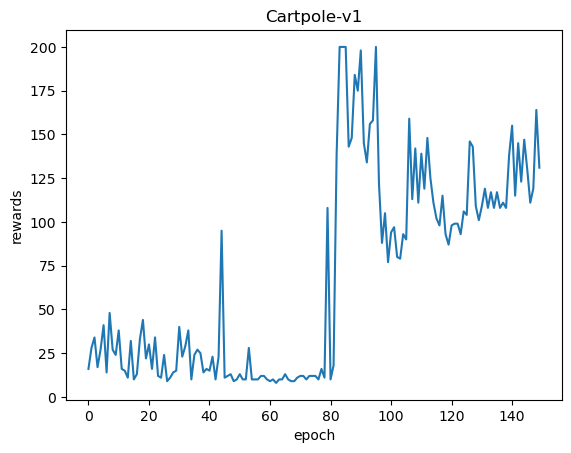

In [1]:
import random
from collections import deque, defaultdict

import numpy as np

import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Input

import matplotlib.pyplot as plt

import gym
from gym import spaces


class ReplayBuffer:
    def __init__(self, buffer_size):
        self.buffer_size = buffer_size
        self.buffer = deque(maxlen=self.buffer_size)
    
    def sample(self, batch_size):
        size = batch_size if len(self.buffer) > batch_size else len(self.buffer)
        return random.sample(self.buffer, size)

    def clear(self):
        self.buffer.clear()
    
    def append(self, transition):
        self.buffer.append(transition)

    def __len__(self):
        return len(self.buffer)


class QNetworkDense(tf.keras.Model):
    def __init__(self, obs_dim, acs_dim):
        super(QNetworkDense, self).__init__()
        self.layer1 = Dense(24, activation='relu', kernel_initializer='he_uniform')
        self.layer2 = Dense(24, activation='relu', kernel_initializer='he_uniform')
        self.output_layer = Dense(acs_dim, activation='linear', kernel_initializer='he_uniform')
        self.build(input_shape=(None,) + obs_dim)

    def call(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        return self.output_layer(x)
        

class Agent(object):
    def __init__(self, env, obs_dim, acs_dim, steps, 
                gamma=0.99, nepsilo=1.0, epsilon_decay=0.999, 
                buffer_size=2000, batch_size=64, target_update_step=100):
        self.env = env
        self.obs_dim = obs_dim
        self.acs_dim = acs_dim
        self.steps = steps
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.buffer_size = buffer_size
        self.target_update_step = target_update_step
        self.batch_size = batch_size

        self.replay_buffer = ReplayBuffer(self.buffer_size)
        
        self.q_fn = QNetworkDense(self.obs_dim, self.acs_dim)
        self.q_fn_target = QNetworkDense(self.obs_dim, self.acs_dim)

        self.q_fn.compile(optimizer='adam', loss='mse')
        self.target_update()
        
        self.loss_fn = tf.keras.losses.MeanSquaredError()
        self.optimizer = tf.keras.optimizers.Adam()


    @tf.function
    def learn(self, obs, acs, next_obs, rewards, dones):
        q_target = rewards + (1 - dones) * self.gamma * tf.reduce_max(self.q_fn_target(next_obs), 
                                                                      axis=1, keepdims=True)

        with tf.GradientTape() as tape:
            qt = self.q_fn(obs)
            acs_onehot = tf.one_hot(tf.cast(tf.reshape(acs, [-1]), tf.int32), self.acs_dim)
            qt = tf.reduce_sum(qt * acs_onehot, axis=1, keepdims=True)
            loss = self.loss_fn(q_target, qt)
        grads = tape.gradient(loss, self.q_fn.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.q_fn.trainable_weights))

    def train(self):
        epochs = 0
        global_step = 0
        reward_list = []
        while global_step < self.steps:
            ob = env.reset()
            rewards = 0
            while True:
                ac = self.select_action(ob)
                next_ob, reward, done, _ = env.step(ac)

                transition = (ob, ac, next_ob, reward, done)
                self.replay_buffer.append(transition)

                rewards += reward
                ob = next_ob

                if done:
                    reward_list.append(rewards)
                    self.target_update()
                    print(f"epochs #{epochs+1} end, score is {rewards}")
                    break

                self.env.render()

                if global_step > 1000:
                    transitions = self.replay_buffer.sample(batch_size=self.batch_size)
                    self.learn(*map(lambda x: np.vstack(x).astype('float32'), np.transpose(transitions)))

                global_step += 1
            epochs += 1
        plt.title('Cartpole-v1')
        plt.xlabel('epoch')
        plt.ylabel('rewards')
        plt.plot(reward_list)
        plt.show()


    def test(self):
        pass

    def target_update(self):
        self.q_fn_target.set_weights(self.q_fn.get_weights())

    def select_action(self, ob):
        self.epsilon *= self.epsilon_decay
        self.epsilon = max(self.epsilon, 0.01)
        if np.random.rand() <= self.epsilon: # exploration
            return np.random.randint(self.acs_dim)
        else:
            action = self.q_fn(ob[np.newaxis])
            return np.argmax(action[0])


if __name__ == '__main__':
    tf.keras.backend.set_floatx('float32')
    env = gym.make('CartPole-v0')

    obs_dim = env.observation_space.shape
    acs_dim = None
    
    if isinstance(env.action_space, spaces.Box):
        acs_type = 'continuous'
        acs_dim = env.action_space.shape
    elif isinstance(env.action_space, spaces.Discrete):
        acs_type = 'discrete'
        acs_dim = env.action_space.n
    else:
        raise NotImplementedError('Not implemented ㅎㅎ')

    agent = Agent(env, obs_dim, acs_dim, 10000)
    agent.train()